# GPM and lightning data analysis
- @author: Hamid Ali Syed
- @email: syed44@purdue.edu
- Date: 26 Oct, 2022
- For lightning dataset info, contact Mr. Abhijeet Gangane (abhijeet.gangane@tropmet.res.in)
- Special thanks for Dr. Randy Chase for making some alterations to DRPy library on the request.
---

## Let's import some necessary tools

In [1]:
import drpy
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import os
import warnings
warnings.filterwarnings("ignore")

## Custom defining plotting parameters

In [2]:
plt.rcParams['axes.labelsize']= 14
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['legend.fontsize']= 14
plt.rcParams['font.size']=14
plt.rcParams['xtick.direction']='in'
plt.rcParams['xtick.major.size']= 5
plt.rcParams['xtick.major.width']= 1
plt.rcParams['xtick.minor.size']= 1.5
plt.rcParams['xtick.minor.width']= 1
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.major.size']= 5
plt.rcParams['ytick.major.width']= 1
plt.rcParams['ytick.minor.size']= 1.5
plt.rcParams['ytick.minor.width']= 1
plt.rcParams['axes.linewidth']= 0.8
plt.rcParams['grid.linewidth']= 0.8

## Creating background Geographic Map

In [3]:
def add_Map(ax, b = 0, t=0, l = 0, r = 0):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.3, 
                         linestyle='-', draw_labels=True)
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right=r
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(feat.BORDERS, lw = 0.5)
    ax.add_feature(feat.LAND, lw = 0.3, fc = [0.9,0.9,0.9])
    ax.add_feature(feat.COASTLINE, lw = 0.5)
    ax.add_feature(feat.OCEAN, alpha = 0.5)
    ax.add_feature(feat.STATES.with_scale("10m"), alpha = 0.5, lw = 0.5)

## Download and read the GPM data
- Here I have defined a function which takes datetime.datetime() input as start_time and end_time arguments
- It will first look for the data locally and will try to read it, otherwise it will download automatically and then read it
- You need to type your email in the username option inplace of **XXXXXXXXX@XXXXX.XXX**
- you need to type the date and time in this manner: **dt.datetime(2016, 2, 28, 15, 0)**
- It will return dpr object (an xarray dataset) using DRPy package

In [4]:
def download_gpm(start_time =dt.datetime(2016, 2, 28, 15, 0),
                 end_time = dt.datetime(2016, 2, 28, 15, 30)):
    file = glob.glob("*"+start_time.strftime("%Y%m%d-S")+"*HDF5")
    if len(file) == 0:
        print("Checking for the files locally...")
        print("Downloading GPM L2 data from PPS Server...")
        io = drpy.io.netrunner(servername="Research", username="hamidsyed37@gmail.com",
                               start_time=start_time, end_time=end_time)
        dpr = drpy.core.GPMDPR(filename=io.filename[0][-64:])
    else:
        print("reading", file[0])
        dpr = drpy.core.GPMDPR(filename=file[0])
    return dpr

In [5]:
dpr = download_gpm(start_time =dt.datetime(2016, 2, 28, 15, 0),
                 end_time = dt.datetime(2016, 2, 28, 15, 30))

reading 2A.GPM.DPR.V9-20211125.20160228-S145020-E162252.011373.V07A.HDF5


In [6]:
dpr.ds

<xarray.Dataset>
Dimensions:                    (nscan: 7932, nrayNS: 49, nfreq: 2, nbin: 176,
                                nNUBF: 3, nNP: 4, method: 2, foreBack: 6,
                                nearFar: 3, nsdew: 2, nfreqHI: 3, nbinSZP: 7)
Coordinates:
    Latitude                   (nscan, nrayNS) float32 ...
    Longitude                  (nscan, nrayNS) float32 ...
    height                     (nscan, nrayNS, nbin) float32 ...
    time                       (nscan, nrayNS) datetime64[ns] 2016-02-28T14:5...
Dimensions without coordinates: nscan, nrayNS, nfreq, nbin, nNUBF, nNP, method,
                                foreBack, nearFar, nsdew, nfreqHI, nbinSZP
Data variables: (12/96)
    sunLocalTime               (nscan, nrayNS) float32 ...
    elevation                  (nscan, nrayNS) float32 ...
    landSurfaceType            (nscan, nrayNS) int32 ...
    localZenithAngle           (nscan, nrayNS, nfreq) float32 ...
    flagPrecip                 (nscan, nrayNS) int32 ...
    flagSigmaZeroSaturation    (nscan, nrayNS, nfreq) uint8 ...
    ...                         ...
    surfaceSnowfallIndex       (nscan, nrayNS) float32 ...
    flagEcho                   (nscan, nrayNS, nbin) int8 ...
    qualityData                (nscan, nrayNS) int32 ...
    qualityFlag                (nscan, nrayNS, nfreq) int8 ...
    flagSensor                 (nscan, nfreq) int8 ...
    flagScanPattern            (nscan, nfreq) int16 ...
Attributes:
    FS_SwathHeader:  NumberScansInSet=1;\nMaximumNumberScansTotal=10000;\nNum...

## Cropping Particular Region

In [7]:
def crop_area(dpr, minlat, maxlat, minlon, maxlon):
    '''
    dpr: GPMDPR object
    minlat(float): minimum latitude, maxlat(float): maximum latitude
    minlon(float): minimum longitude, maxlon(float): maximum longitude
    '''
    cropped_area = dpr.ds.where((dpr.ds["Longitude"] >= minlon) & (dpr.ds["Longitude"] <= maxlon) &
             (dpr.ds["Latitude"] >= minlat) & (dpr.ds["Latitude"] <= maxlat), drop=True)
    return cropped_area

## Read lightning data
- Function to read the lightning data after refining it a little

In [8]:
def read_lightning(filename):
    '''filename(str)'''
    df16 = pd.read_csv(filename)
    df16['time'] = pd.to_datetime(df16['LightningTimeString'])
    df16 = df16[['time','Height','Longitude','Latitude','StrokeType']]
    return df16

In [9]:
df16 = read_lightning("Data/28feb16/14.49to15.49.csv")

# {-}

Crop a region using custom function crop_area() for the analysis

In [10]:
minlat=15
maxlat=22
minlon=70
maxlon=80
india = crop_area(dpr, minlat, maxlat, minlon, maxlon)

In [11]:
def plot_vert(india, df16, ax, l=None, b = None, fig=None, colorbar = True, xlim = (18.5,19.5), savefig=False):
    gpmplot = india['zFactorFinal'].isel(nfreq = 0)[:,48,:].plot(y = "height", x = "Latitude", 
                                                       vmin = -10, vmax = 60,
                                                       ylim = (0,12e3),
                                                       xlim = xlim,
                                                       cmap=drpy.graph.cmaps.HomeyerRainbow,
                                                       add_colorbar = False,
                                                       ax = ax)
    if colorbar:
        cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.03],)#lbwh
        cbar1 = fig.colorbar(gpmplot, cax=cbar_ax,orientation='horizontal')
        cbar1.set_label('zFactorFinal $[dBZ]$')
    ax.set_title(pd.to_datetime(india['zFactorFinal'].isel(nfreq=0).time[0,0].values).strftime('%Y-%m-%d %H:%M'))

    df16[df16["StrokeType"] == 1].plot(x = "Latitude", y = "Height", 
                                       kind = "scatter",  alpha = 0.5, 
                                       marker = "X", s = 100, label = "IC", ec = "k", fc = "w",
                                      ylim = (0,12e3), xlim = xlim, ax=ax, xlabel=None)
    ax.set_ylabel("Height $[m]$")
    ax.set_xlabel("")
    
    if l is not True:
        ax.set_yticklabels("")
    if b is not True:
        ax.set_xticklabels("")
    else:
        ax.set_xlabel("Latitude $[˚N]$")
    if savefig:
        plt.savefig("vertical_ic_"+df16[["time"]].iloc[0].dt.strftime("%Y%m%d")[0]+".png",
                        dpi = 600, bbox_inches = 'tight')

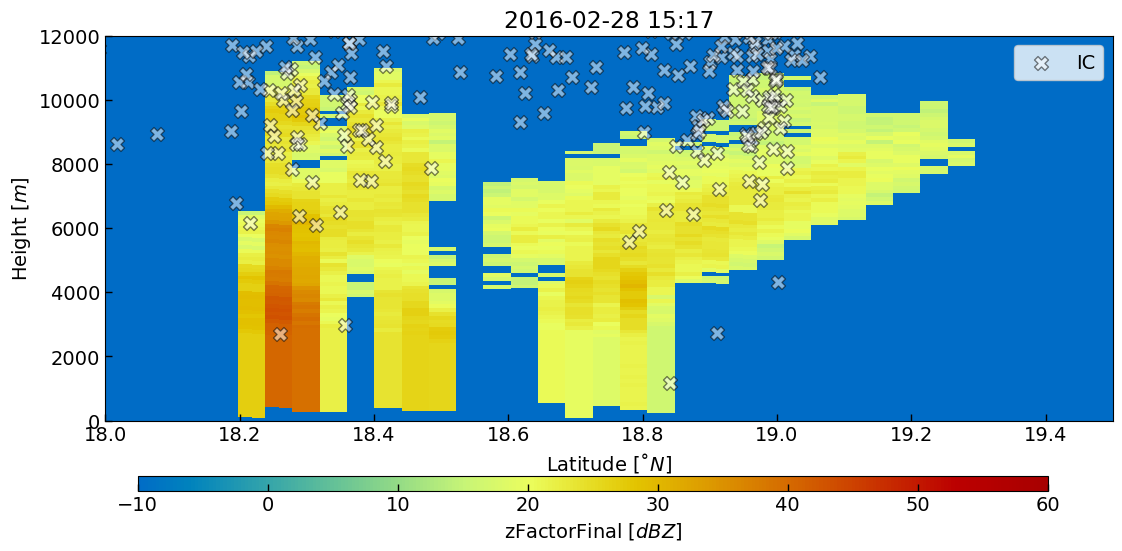

In [12]:
fig = plt.figure(figsize = [13, 5])
ax = plt.axes()
plot_vert(india, df16, ax=ax,l=True, b=True, fig=fig, colorbar=True, xlim = (18,19.5), savefig=True)

In [13]:
def horizontal_plot(india, df16, savefig = False, xlim = (73,77), ylim = (17,20), s = 2):
    fig = plt.figure(figsize = [13, 5], tight_layout = True)
    ax = plt.subplot(121, projection=ccrs.PlateCarree())
    ax.set_extent([minlon+3, maxlon-3, minlat+2, maxlat-2])
    gpmplot = india['zFactorFinal'].isel(nfreq=0).max(axis=2).plot.pcolormesh(x='Longitude',y='Latitude',
                                                                    vmin = 0, vmax = 60,
                                                                    cmap=drpy.graph.cmaps.HomeyerRainbow,
                                                                              add_colorbar = False)
    ax.set_title(pd.to_datetime(india['zFactorFinal'].isel(nfreq=0).time[0,0].values).strftime('%Y-%m-%d %H:%M'))
    sctr = df16[df16["StrokeType"] == 1].plot(x = "Longitude", y = "Latitude", 
                                       kind = "scatter",  alpha = 0.2, marker = "X", 
                                              s = s, ax=ax, label = "IC"+":"+str(len(df16[df16["StrokeType"] == 1])),
                                              ec = "k", fc = "k",
                                              ylim = ylim,
                                              xlim = xlim,)
    add_Map(ax,b=1, l=1)
    ax = plt.subplot(122, projection=ccrs.PlateCarree())

    ax.set_extent([minlon+3, maxlon-3, minlat+2, maxlat-2])
    gpmplot = india['zFactorFinal'].isel(nfreq=0).max(axis=2).plot.pcolormesh(x='Longitude',y='Latitude',
                                                                    vmin = 0, vmax = 60,
                                                                    cmap=drpy.graph.cmaps.HomeyerRainbow,
                                                                             add_colorbar = False)
    ax.set_title(pd.to_datetime(india['zFactorFinal'].isel(nfreq=0).time[0,0].values).strftime('%Y-%m-%d %H:%M'))

    sctr = df16[df16["StrokeType"] == 0].plot(x = "Longitude", y = "Latitude", 
                                       kind = "scatter",  alpha = 0.2, marker = "X", 
                                              s = s, ax=ax, label = "CG"+":"+str(len(df16[df16["StrokeType"] == 0])),
                                              ec = "k", fc = "k",
                                              ylim = ylim,
                                              xlim = xlim,)

    cbar_ax = fig.add_axes([0.15, -0.03, 0.75, 0.03],)#lbwh
    cbar1 = fig.colorbar(gpmplot, cax=cbar_ax,orientation='horizontal')
    cbar1.set_label('zFactorFinal $[dBZ]$')

    add_Map(ax, b=1,)
    if savefig:
        plt.savefig("horizontal_ic_cg_"+df16[["time"]].iloc[0].dt.strftime("%Y%m%d")[0]+".png",
                    dpi = 600, bbox_inches = 'tight')
    plt.show()

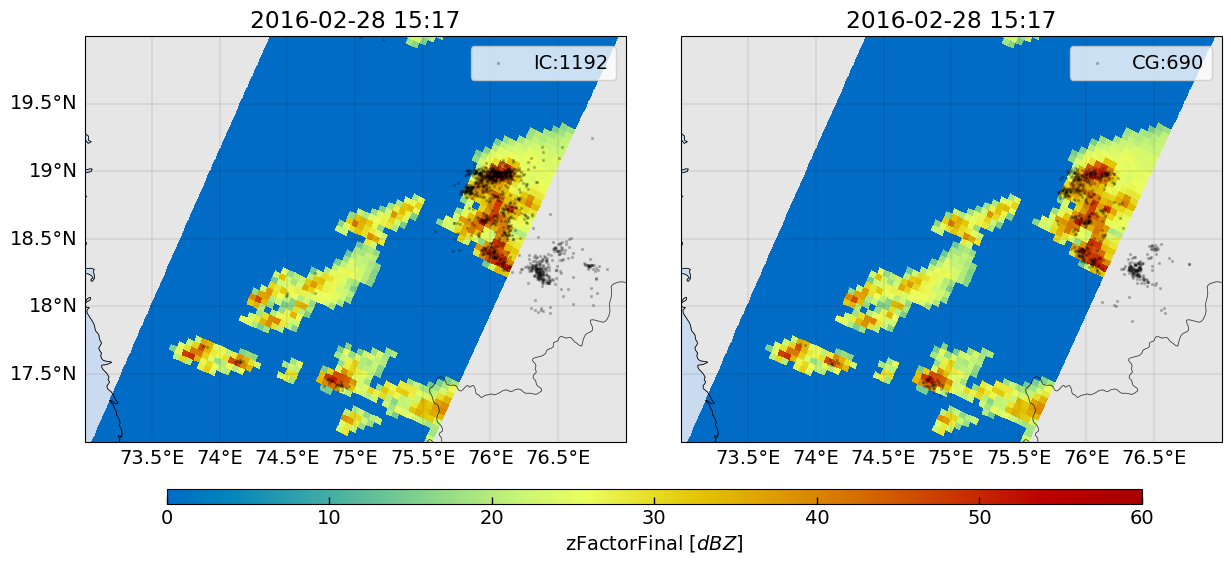

In [14]:
horizontal_plot(india, df16, savefig=True)

---

# Lets analyze another case {-}

In [15]:
from IPython.display import IFrame
IFrame("https://sharaku.eorc.jaxa.jp/trmm/RT3/index.html", width=800, height=500)

## Load the data

### Lightning

In [16]:
df21 = read_lightning(filename="Data/18feb21/11.17to12.17.csv")
df21

,time,Height,Longitude,Latitude,StrokeType
0,2021-02-18 11:17:00.838935136,0,73.91856,20.51533,0
1,2021-02-18 11:17:11.480944812,19084,73.84604,19.75369,1
2,2021-02-18 11:17:16.605442523,0,76.23387,20.41201,0
3,2021-02-18 11:17:18.035577356,0,80.53286,20.72732,0
4,2021-02-18 11:17:18.561332583,13113,73.97190,18.00210,1
...,...,...,...,...,...
979,2021-02-18 12:17:31.352757334,0,73.92654,17.29739,0
980,2021-02-18 12:17:37.916778385,17909,73.58365,18.87397,1
981,2021-02-18 12:17:48.113721609,0,73.14580,19.78355,0
982,2021-02-18 12:17:52.997322261,0,73.82375,20.32237,0


### GPM

In [17]:
dpr = download_gpm(dt.datetime(2021, 2, 18, 11, 40), dt.datetime(2021, 2, 18, 11, 50))

reading 2A.GPM.DPR.V9-20211125.20210218-S111813-E125047.039635.V07A.HDF5


## Define a region

In [18]:
minlat=18.5
maxlat=23
minlon= 76.5
maxlon=82
india = crop_area(dpr, minlat, maxlat, minlon, maxlon)

### Plot GPM Horizontal using the custom function horizontal_plot()

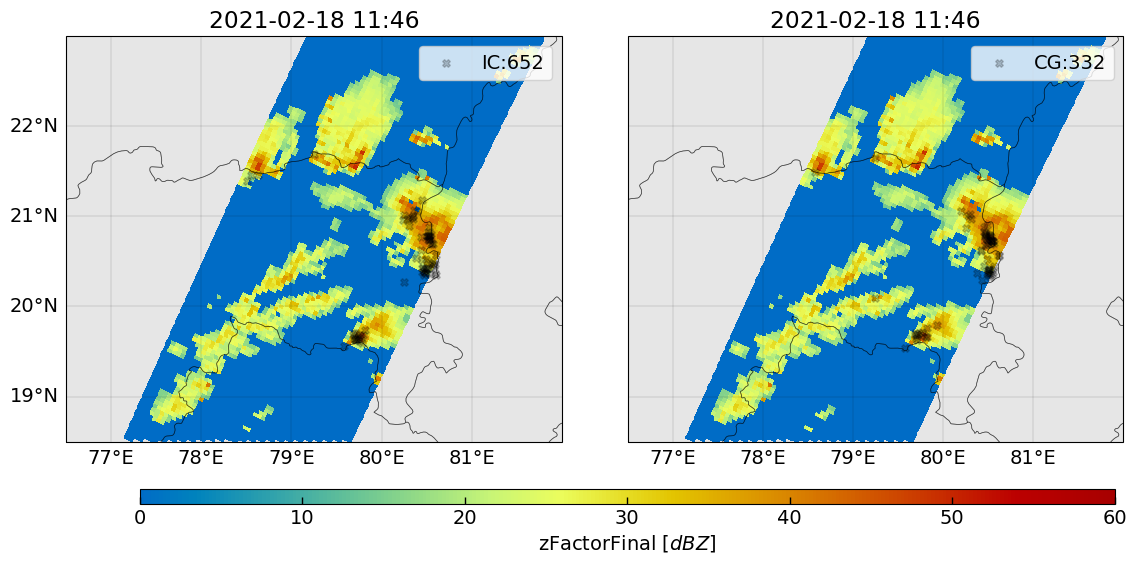

In [19]:
horizontal_plot(india, df21,savefig=True, xlim=(minlon, maxlon), ylim=(minlat, maxlat), s=30)

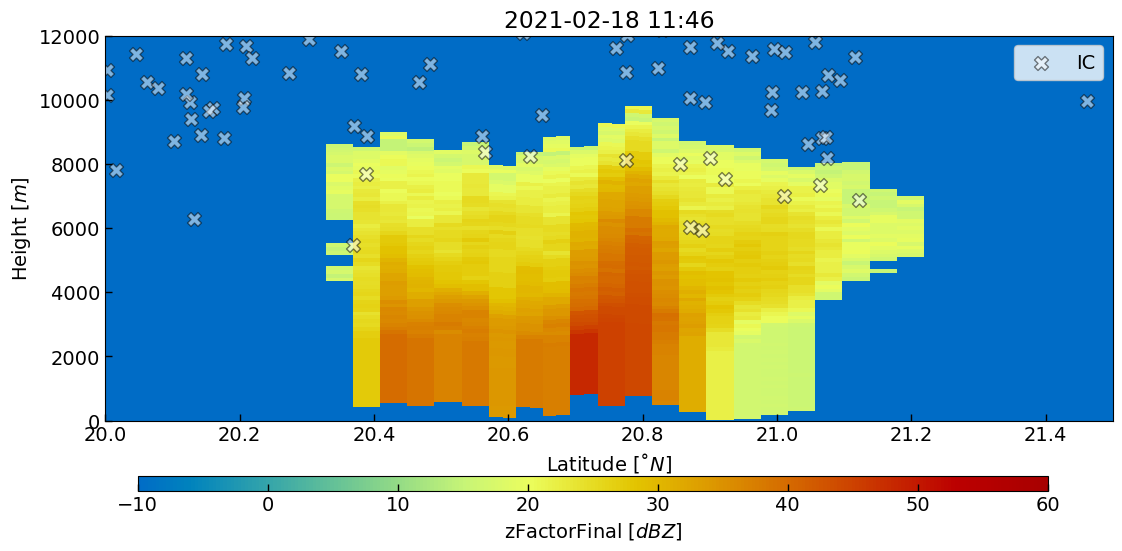

In [20]:
fig = plt.figure(figsize = [13, 5])
ax = plt.axes()
plot_vert(india, df21, ax=ax,l=True, b=True, fig=fig, colorbar=True, xlim=(20,21.5), savefig=True)

## Lets analyze another case {-}

## Load the data

### Lightning

In [21]:
df15 = pd.read_csv("Data/28feb15/12.06to13.06.csv", header=None)
df15

,0,1,2,3,4,5,6,7,8,9,10
0,2015,2,28,12,6,16.730,19.519,78.212,14162,1,-5939.0
1,2015,2,28,12,6,20.397,21.448,78.760,0,0,-35484.0
2,2015,2,28,12,6,22.027,19.749,77.860,15532,1,1907.0
3,2015,2,28,12,6,26.767,19.723,77.823,10005,1,3814.0
4,2015,2,28,12,6,27.106,20.971,76.965,17708,1,5941.0
...,...,...,...,...,...,...,...,...,...,...,...
1532,2015,2,28,13,6,14.131,20.685,78.238,0,0,-7785.0
1533,2015,2,28,13,6,33.092,20.825,77.397,19548,1,11209.0
1534,2015,2,28,13,6,36.418,20.491,77.989,12765,1,-10213.0
1535,2015,2,28,13,6,46.411,21.645,77.498,0,0,46265.0


Since the data is messy, let's refine it first

In [22]:
time = pd.to_datetime(df15.iloc[:,0].astype(str)+"-"+df15.iloc[:,1].astype(str)+"-\
"+df15.iloc[:,2].astype(str)+"T"+df15.iloc[:,3].astype(str)+":"+df15.iloc[:,4].astype(str))

In [23]:
df15['time'] = time

In [24]:
df15 = df15[["time",6,7,8,9,]]

In [25]:
df15 = df15.rename({8:"Height",6:"Latitude",7:"Longitude",9:"StrokeType"}, axis = "columns")
df15

,time,Latitude,Longitude,Height,StrokeType
0,2015-02-28 12:06:00,19.519,78.212,14162,1
1,2015-02-28 12:06:00,21.448,78.760,0,0
2,2015-02-28 12:06:00,19.749,77.860,15532,1
3,2015-02-28 12:06:00,19.723,77.823,10005,1
4,2015-02-28 12:06:00,20.971,76.965,17708,1
...,...,...,...,...,...
1532,2015-02-28 13:06:00,20.685,78.238,0,0
1533,2015-02-28 13:06:00,20.825,77.397,19548,1
1534,2015-02-28 13:06:00,20.491,77.989,12765,1
1535,2015-02-28 13:06:00,21.645,77.498,0,0


### GPM

In [60]:
dpr = download_gpm(dt.datetime(2015, 2, 28, 12, 30), dt.datetime(2015, 2, 28, 13, 0))

reading 2A.GPM.DPR.V9-20211125.20150228-S113318-E130552.005692.V07A.HDF5


## Define a region

In [61]:
dpr.ds

<xarray.Dataset>
Dimensions:                    (nscan: 7936, nrayNS: 49, nfreq: 2, nbin: 176,
                                nNUBF: 3, nNP: 4, method: 2, foreBack: 6,
                                nearFar: 3, nsdew: 2, nfreqHI: 3, nbinSZP: 7)
Coordinates:
    Latitude                   (nscan, nrayNS) float32 ...
    Longitude                  (nscan, nrayNS) float32 ...
    height                     (nscan, nrayNS, nbin) float32 ...
    time                       (nscan, nrayNS) datetime64[ns] 2015-02-28T11:3...
Dimensions without coordinates: nscan, nrayNS, nfreq, nbin, nNUBF, nNP, method,
                                foreBack, nearFar, nsdew, nfreqHI, nbinSZP
Data variables: (12/96)
    sunLocalTime               (nscan, nrayNS) float32 ...
    elevation                  (nscan, nrayNS) float32 ...
    landSurfaceType            (nscan, nrayNS) int32 ...
    localZenithAngle           (nscan, nrayNS, nfreq) float32 ...
    flagPrecip                 (nscan, nrayNS) int32 ...
    flagSigmaZeroSaturation    (nscan, nrayNS, nfreq) uint8 ...
    ...                         ...
    surfaceSnowfallIndex       (nscan, nrayNS) float32 ...
    flagEcho                   (nscan, nrayNS, nbin) int8 ...
    qualityData                (nscan, nrayNS) int32 ...
    qualityFlag                (nscan, nrayNS, nfreq) int8 ...
    flagSensor                 (nscan, nfreq) int8 ...
    flagScanPattern            (nscan, nfreq) int16 ...
Attributes:
    FS_SwathHeader:  NumberScansInSet=1;\nMaximumNumberScansTotal=10000;\nNum...

In [83]:
minlat=18.5
maxlat=24
minlon= 76.5
maxlon=82
india = crop_area(dpr, minlat, maxlat, minlon, maxlon)

### Plot GPM Horizontal using the custom function horizontal_plot()

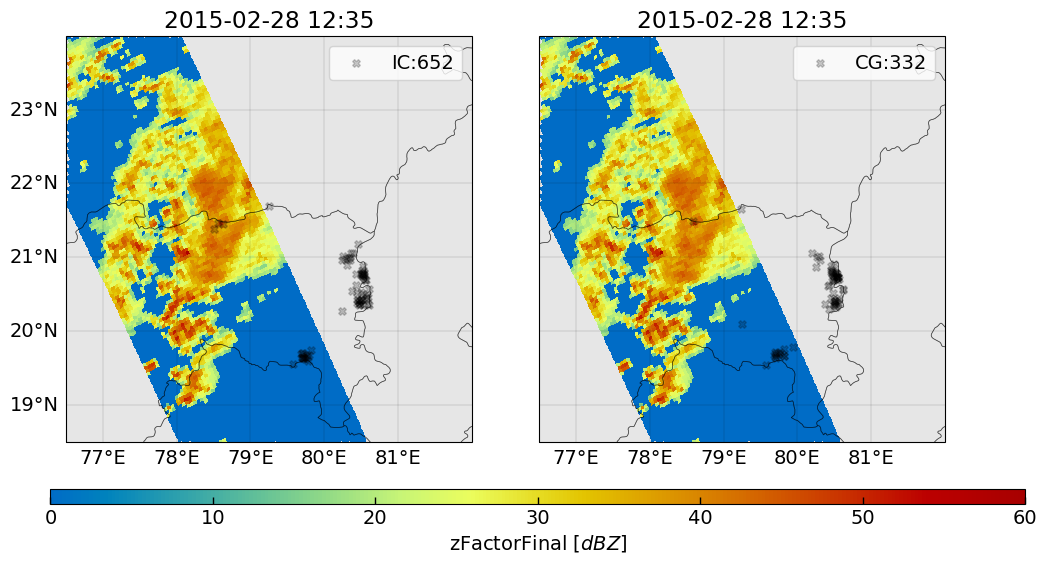

In [84]:
horizontal_plot(india, df21,savefig=True, xlim=(minlon, maxlon), ylim=(minlat, maxlat), s=30)

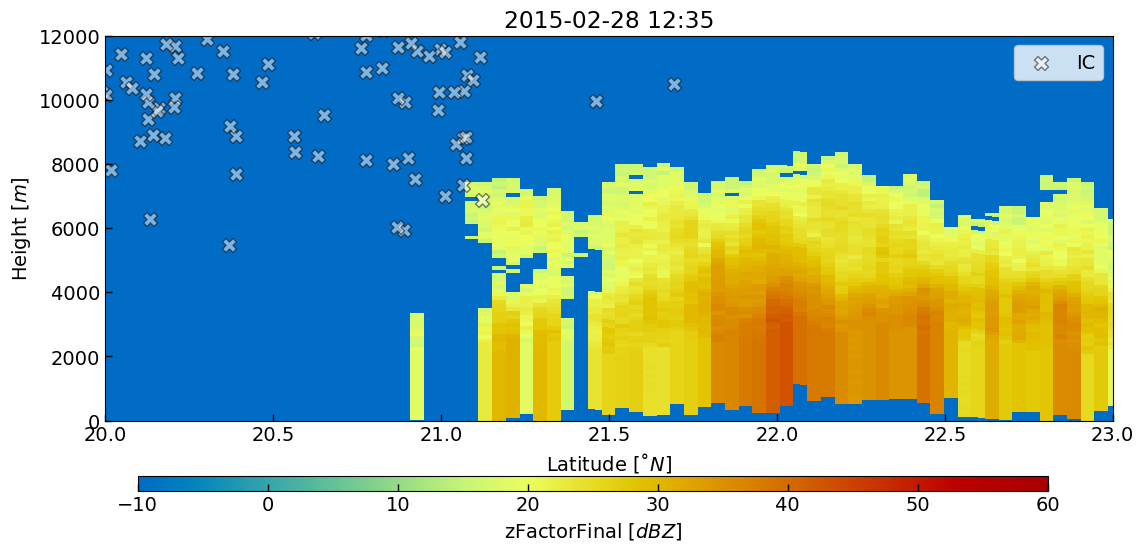

In [85]:
fig = plt.figure(figsize = [13, 5])
ax = plt.axes()
plot_vert(india, df21, ax=ax,l=True, b=True, fig=fig, colorbar=True, xlim=(20,23), savefig=True)

---

## Summary

- The Global Precipitation Measurement (GPM) project, a collaboration between NASA and the Japanese Aerospace Exploration Agency (JAXA), provides the most advanced data on precipitation and snow within latitudes around $\pm65°$. The quasi-vertical reflectivity profiles produced by the Ku-component (13.6 GHz) of Dual-Frequency Precipitation Radar (DPR) on board the GPM core observatory satellite cover a swath width of approximately 250 km. The horizontal and vertical resolutions of GPM-KuPR are approximately 5 km and 250 m, respectively. The GPM data has been available since March 2014. The GPM-2AKu contains data for the corrected reflectivity factor (zFactorFinal) used in this study [1].
- The horizontal and vertical reflectivity (zFactorFinal) were plotted using level 2 DPR-Ku data using a python package DRPy.

## References
1. Toshio Iguchi, Robert Meneghini (2021), GPM DPR Precipitation Profile L2A 1.5 hours 5 km V07, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), https://doi.org/10.5067/GPM/DPR/GPM/2A/07
2. Randy J. Chase, & Hamid Ali Syed. (2022). dopplerchase/DRpy: First major release (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.7259561